# Active Learning - Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [1]:
%run set_environment

## Bibliotecas

In [2]:
#importing_libraries.py

import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from copy import deepcopy

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn import preprocessing

In [6]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [7]:
from timeit import default_timer as timer

In [8]:
from scipy.io import arff

In [9]:
from tqdm.autonotebook import tqdm, trange

## Classificadores

### Algoritmos

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Conjunto de dados

In [11]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

In [12]:
# Datasets OpenML
import openml
import os

In [13]:
openml.config.cache_directory = os.path.expanduser('./datasets/openML')
openml_list = openml.datasets.list_datasets()

datalist = pd.DataFrame.from_dict(openml_list, orient="index")
datalist = list(datalist[(datalist.NumberOfClasses.isnull() == False) & (datalist.NumberOfClasses != 0)]["did"])

## Estatratégias

### Amostra por incerteza

In [14]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_test, y_test = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    #cls = which_classifier(classifier)
    #cls.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]
        
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Uncertain Sampling"}

### Amostragem aleatória

In [15]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1, cost+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        #training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][TRAIN]]), size=k+i) #high = qtd elementos na bag
        #sample_size = sample_size + len(training_indices)
        #X_train = X_raw[idx_data[idx_bag][TRAIN][training_indices]] #ASK06
        #y_train = y_raw[idx_data[idx_bag][TRAIN][training_indices]]
        #X_test = np.delete(X_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)
        #y_test = np.delete(y_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)
        
        cls = which_classifier(classifier)
        cls.fit(X_train, y_train)

        random_sampling_score = cls.score(X_test,y_test)
        performance_history.append(random_sampling_score)

        
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw),
             "Strategy": "Random Sampling"}

### Consulta por comitê

In [16]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    learner_list = []

    for j in range(1, cost+1): # Loop para criação do comitê

        X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
        sample_size = sample_size + len(X_train)

        # initializing learner
        learner = ActiveLearner(
            estimator= which_classifier(classifier),
            X_training = X_train, y_training = y_train 
        )
        learner_list.append(learner)

    # assembling the committee
    committee = Committee(
        learner_list=learner_list,
        query_strategy=vote_entropy_sampling)

    #X_pool, y_pool = X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]]
    
    # query by committee
    for idx in range(cost):
        print("\t Size of X_pool:", len(X_pool))
        query_idx, query_instance = committee.query(X_pool, n_instances = init_size+1)
        sample_size = sample_size + len(query_idx)
        
        committee.teach(
            X = X_pool[query_idx],
            y = y_pool[query_idx]
        )

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
        query_by_committee_score = committee.score(X_pool, y_pool)
        performance_history.append(query_by_committee_score)

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw),
             "Strategy": "Query by Committee"}

In [17]:
%run -i main.py

NameError: name 'datasets' is not defined

### Expected Error Reduction

In [18]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)[0]

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
    
        X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        y_pool = np.delete(y_pool, exp_error_idx)
        
        exp_er_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Error Reduction"}

### Expected Model Change

In [19]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    #initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    #X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    #X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    X_train, X_pool, y_train, y_pool = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        print("\t Size of X_pool:", len(X_pool))
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)

        if score_aux > score_learner:
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        
        X_pool = np.delete(X_pool, exp_error_idx, axis=0)
        y_pool = np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_mo_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_mo_score)

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Model Change"}

## Query highest LSC

In [45]:
def highest_lsc_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    X_rawAndY_raw = np.column_stack([X_raw[idx_data[idx_bag][TRAIN]],y_raw[idx_data[idx_bag][TRAIN]]])
    np.savetxt("data.csv", X_rawAndY_raw, fmt='%i', delimiter=",")
    
    which_pyhard_measure('LSC')

    !pyhard --no-isa

    df = pd.read_csv('metadata.csv')

    idx = list(df.sort_values(by='feature_LSC', ascending=False)['instances'][:cost])

    X_train = X_raw[idx_data[idx_bag][TRAIN][idx]]
    y_train = y_raw[idx_data[idx_bag][TRAIN][idx]]

    sample_size = cost
    learner.teach(X_train, y_train)
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Highest LSC Sampling"}

# Query highest Usefulness

In [46]:
def highest_usefulness_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    print(type(X_raw[idx_data[idx_bag][TRAIN]]))

    X_rawAndY_raw = np.column_stack([X_raw[idx_data[idx_bag][TRAIN]],y_raw[idx_data[idx_bag][TRAIN]]])
    np.savetxt("data.csv", X_rawAndY_raw, fmt='%i', delimiter=",")
    
    which_pyhard_measure('Usefulness')

    !pyhard --no-isa

    df = pd.read_csv('metadata.csv')

    idx = list(df.sort_values(by='feature_Usefulness', ascending=False)['instances'][:cost])

    X_train = X_raw[idx_data[idx_bag][TRAIN][idx]]
    y_train = y_raw[idx_data[idx_bag][TRAIN][idx]]

    sample_size = cost
    learner.teach(X_train, y_train)
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Highest Usefulness Sampling"}

# Query lowest Harmfulness

In [65]:
def lowest_harmfulness_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)) + init_size, stratify = y_raw[idx_data[idx_bag][TRAIN]])
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    print(type(X_raw[idx_data[idx_bag][TRAIN]]))

    X_rawAndY_raw = np.column_stack([X_raw[idx_data[idx_bag][TRAIN]],y_raw[idx_data[idx_bag][TRAIN]]])
    np.savetxt("data.csv", X_rawAndY_raw, fmt='%i', delimiter=",")
    
    which_pyhard_measure('Harmfulness')

    !pyhard --no-isa

    df = pd.read_csv('metadata.csv')

    idx = list(df.sort_values(by='feature_Harmfulness', ascending=True)['instances'][:cost])

    X_train = X_raw[idx_data[idx_bag][TRAIN][idx]]
    y_train = y_raw[idx_data[idx_bag][TRAIN][idx]]

    sample_size = cost
    learner.teach(X_train, y_train)
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size / len(X_raw), # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Lowest Harmfulness Sampling"}

## Setup

In [47]:
def which_pyhard_measure(measure='LSC'):
    import yaml
    with open(r'config-template.yaml') as file:
        configs_list = yaml.load(file, Loader=yaml.FullLoader)

        if measure == 'LSC':
            configs_list['measures_list'] = ['LSC']
        elif measure == 'Harmfulness':
            configs_list['measures_list'] = ['Harmfulness']
        elif measure == 'Usefulness':
            configs_list['measures_list'] = ['Usefulness']

    with open(r'config.yaml', 'w') as file:
        yaml.dump(configs_list, file)


In [21]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [22]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [23]:
def which_arff_dataset(dataset, n_splits = 5):
   
    from sklearn.preprocessing import OrdinalEncoder
    
    data = arff.loadarff('datasets/luis/' + dataset)
    data = pd.DataFrame(data[0])

    X_raw = data[data.columns[:-1]].to_numpy()
    y_raw = data[data.columns[-1]].to_numpy()
    
    lex = preprocessing.OrdinalEncoder()
    lex.fit(X_raw)
    X_raw = lex.transform(X_raw)
        
    ley = preprocessing.LabelEncoder()
    ley.fit(y_raw)
    y_raw = ley.transform(y_raw)
    
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    data_cv.get_n_splits(X_raw,y_raw)
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw, y_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, dataset

In [24]:
def which_classifier(classifier = '5NN'):
    
    if (classifier == '5NN'):
        return KNeighborsClassifier(5)
    elif (classifier == 'C4.5'):
        return tree.DecisionTreeClassifier()
    elif (classifier == 'NB'):
        return GaussianNB()
    elif (classifier == 'SVM'):
        return SVC(probability=True, gamma='auto')
    elif (classifier == 'RF'):
        return RandomForestClassifier()

In [25]:
def fetch_datasets(dataset):
    
    data = arff.loadarff('./datasets/luis/' + dataset)
    metadata = data[1]
    data = pd.DataFrame(data[0])
    
    instances = len(data)
    classes = len(data.iloc[:,-1].value_counts())
    attributes = len(data.columns)- 1
    nominal_attributes = str(metadata).count("nominal")
    
    proportion = data.iloc[:,-1].value_counts()
    proportion = proportion.map(lambda x: round(x/instances*100,2))

    majority = max(proportion)
    minority = min(proportion)

    
    return {
        "name": dataset[:-5],
        "instances": instances,
        "classes": classes,
        "attributes": attributes,
        "nominal attributes": nominal_attributes,
        "majority": majority,
        "minority": minority
    }

In [26]:
datasets = os.listdir('./datasets/luis')
classifiers = ['5NN', 'C4.5', 'NB','RF']
total_performance_history = []

In [27]:
datasets

['61_iris.arff']

In [28]:
metadata = []

for ds in datasets:
    metadata.append(fetch_datasets(ds))

metadata = pd.DataFrame.from_dict(metadata)
metadata

,name,instances,classes,attributes,nominal attributes,majority,minority
0,61_iris,150,3,4,1,33.33,33.33


In [30]:
#tqdm_datasets = tqdm(datasets, desc=" Dataset: "+ str(ds[:-5]))
#tqdm_classifier = tqdm(classifiers, desc="Classifier: "+ str(classifier))

for ds in tqdm(datasets,  desc ="Dataset"):
    for classifier in tqdm(classifiers,  desc ="Classifier"):
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)

        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in tqdm(range(n_splits),  desc ="Bag"):
#             tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " uncertain_sampling")
#             result = uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
#             result['dataset'] = ds[:-5]
#             total_performance_history.append(result)
#             tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " uncertain_sampling")
            
#             tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " random_sampling")
#             result = random_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
#             result['dataset'] = ds[:-5]
#             total_performance_history.append(result)
#             tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " random_sampling")
            
#             tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " query_by_committee")
#             result = query_by_committee(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
#             result['dataset'] = ds[:-5]
#             total_performance_history.append(result)
#             tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " query_by_committee")

            tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " exp_error_reduction")
            result = exp_error_reduction(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
            tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " exp_error_reduction")
            
#             tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " exp_model_change")
#             result = exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
#             result['dataset'] = ds[:-5]
#             total_performance_history.append(result)
#             tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " exp_model_change")

Testando: 61_iris 5NN 0/5 exp_error_reduction
	 Size of X_pool: 45





TypeError: Singleton array array(1) cannot be considered a valid collection.

In [48]:
classifiers = ['RF']
total_performance_history = []

In [66]:
#tqdm_datasets = tqdm(datasets, desc=" Dataset: "+ str(ds[:-5]))
#tqdm_classifier = tqdm(classifiers, desc="Classifier: "+ str(classifier))

for ds in tqdm(datasets,  desc ="Dataset"):
    for classifier in tqdm(classifiers,  desc ="Classifier"):
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
        

        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in tqdm(range(n_splits),  desc ="Bag"):

            tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " highest_lsc_sampling")
            result = highest_lsc_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
            tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " highest_lsc_sampling")
            
            tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " highest_usefulness_sampling")
            result = highest_usefulness_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
            tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " highest_usefulness_sampling")
           
            tqdm.write("Testando: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " lowest_harmfulness_sampling")
            result = lowest_harmfulness_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
            tqdm.write("Passou: " + str(ds[:-5]) + " " + str(classifier) + " " + str(idx_bag) + "/" + str(n_splits) + " lowest_harmfulness_sampling")
  

Testando: 61_iris RF 0/5 highest_lsc_sampling
run 'pyhard --help' to see all options.
[INFO] 2021-04-13 21:00:08,750 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-13 21:00:08,751 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-13 21:00:08,753 - Type of problem: 'classification'
[INFO] 2021-04-13 21:00:08,753 - Building metadata.
[INFO] 2021-04-13 21:00:10,108 - Calculating measure 'LSC'
[INFO] 2021-04-13 21:00:10,130 - Hyper parameter optimization enabled
[INFO] 2021-04-13 21:00:10,130 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-13 21:00:10,130 - Estimating instance performance...
[INFO] 2021-04-13 21:00:10,131 - Evaluating testing fold #1
[INFO] 2021-04-13 21:00:10,131 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:05<00:00,  3.37trial/s, best loss: -0.915784832451

[INFO] 2021-04-13 21:01:43,515 - Calculating measure 'LSC'
[INFO] 2021-04-13 21:01:43,538 - Hyper parameter optimization enabled
[INFO] 2021-04-13 21:01:43,538 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-13 21:01:43,538 - Estimating instance performance...
[INFO] 2021-04-13 21:01:43,539 - Evaluating testing fold #1
[INFO] 2021-04-13 21:01:43,539 - Optimizing classifier hyper-parameters
100%|█████████| 20/20 [00:05<00:00,  3.34trial/s, best loss: -0.939594356261023]
[INFO] 2021-04-13 21:01:49,764 - Test fold mean accuracy: 1.0
[INFO] 2021-04-13 21:01:49,764 - Evaluating testing fold #2
[INFO] 2021-04-13 21:01:49,765 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:05<00:00,  3.64trial/s, best loss: -0.9519400352733686]
[INFO] 2021-04-13 21:01:55,283 - Test fold mean accuracy: 1.0
[INFO] 2021-04-13 21:01:55,283 - Evaluating testing fold #3
[INFO] 2021-04-13 21:01:55,283 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:04<00:00,  

100%|█████████| 20/20 [00:05<00:00,  3.62trial/s, best loss: -0.951058201058201]
[INFO] 2021-04-13 21:03:28,302 - Test fold mean accuracy: 0.9523809523809523
[INFO] 2021-04-13 21:03:28,302 - Evaluating testing fold #3
[INFO] 2021-04-13 21:03:28,303 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:03<00:00,  5.11trial/s, best loss: -0.9514991181657848]
[INFO] 2021-04-13 21:03:32,256 - Test fold mean accuracy: 0.9047619047619048
[INFO] 2021-04-13 21:03:32,256 - Evaluating testing fold #4
[INFO] 2021-04-13 21:03:32,257 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:05<00:00,  3.77trial/s, best loss: -0.9391534391534391]
[INFO] 2021-04-13 21:03:37,588 - Test fold mean accuracy: 0.9047619047619048
[INFO] 2021-04-13 21:03:37,589 - Evaluating testing fold #5
[INFO] 2021-04-13 21:03:37,589 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:04<00:00,  4.02trial/s, best loss: -0.9166666666666666]
[INFO] 2021-04-13 21:03:42,605 - Test fold mean a

100%|████████| 20/20 [00:05<00:00,  3.37trial/s, best loss: -0.9514991181657848]
[INFO] 2021-04-13 21:05:27,488 - Test fold mean accuracy: 0.9523809523809523
[INFO] 2021-04-13 21:05:27,488 - Evaluating testing fold #5
[INFO] 2021-04-13 21:05:27,489 - Optimizing classifier hyper-parameters
100%|████████| 20/20 [00:06<00:00,  3.32trial/s, best loss: -0.9523809523809524]
[INFO] 2021-04-13 21:05:33,782 - Test fold mean accuracy: 0.95
[INFO] 2021-04-13 21:05:33,782 - Iteration 1/1 completed.
[INFO] 2021-04-13 21:05:33,782 - Mean accuracy on test instances (iteration #1): 0.9519
[INFO] 2021-04-13 21:05:33,788 - Total elapsed time: 30.7s
[INFO] 2021-04-13 21:05:33,788 - Instance Hardness analysis finished.
Passou: 61_iris RF 3/5 highest_lsc_sampling
Testando: 61_iris RF 3/5 highest_usefulness_sampling
<class 'numpy.ndarray'>
run 'pyhard --help' to see all options.
[INFO] 2021-04-13 21:05:36,808 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len la

[INFO] 2021-04-13 21:07:09,391 - Total elapsed time: 28.8s
[INFO] 2021-04-13 21:07:09,391 - Instance Hardness analysis finished.
Passou: 61_iris RF 4/5 highest_lsc_sampling
Testando: 61_iris RF 4/5 highest_usefulness_sampling
<class 'numpy.ndarray'>
run 'pyhard --help' to see all options.
[INFO] 2021-04-13 21:07:12,384 - Configuration file: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/config.yaml'
[INFO] 2021-04-13 21:07:12,384 - Reading input dataset: '/Users/tiagocabral/Documents/UnB/EstudosEmIA/active_learning/data/act_len labs/pyhard/data.csv'
[INFO] 2021-04-13 21:07:12,386 - Type of problem: 'classification'
[INFO] 2021-04-13 21:07:12,386 - Building metadata.
[INFO] 2021-04-13 21:07:13,906 - Calculating measure 'Usefulness'
[INFO] 2021-04-13 21:07:13,908 - Hyper parameter optimization enabled
[INFO] 2021-04-13 21:07:13,908 - Assessing performance of classifier 'random_forest'
[INFO] 2021-04-13 21:07:13,908 - Estimating instance performance

In [67]:
total_performance_history

[{'performance_history': 0.9484536082474226,
  'time_elapsed': 46.410336223000286,
  'classifier': 'RF',
  'sample_size': 0.06666666666666667,
  'Strategy': 'Highest LSC Sampling',
  'dataset': '61_iris'},
 {'performance_history': 1.0,
  'time_elapsed': 43.47225970399995,
  'classifier': 'RF',
  'sample_size': 0.06666666666666667,
  'Strategy': 'Highest LSC Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.9587628865979382,
  'time_elapsed': 39.61375497200015,
  'classifier': 'RF',
  'sample_size': 0.06666666666666667,
  'Strategy': 'Highest LSC Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.9587628865979382,
  'time_elapsed': 36.04979556900025,
  'classifier': 'RF',
  'sample_size': 0.06666666666666667,
  'Strategy': 'Highest LSC Sampling',
  'dataset': '61_iris'},
 {'performance_history': 0.9587628865979382,
  'time_elapsed': 40.71912481800018,
  'classifier': 'RF',
  'sample_size': 0.06666666666666667,
  'Strategy': 'Highest LSC Sampling',
  'dataset': '

## Visualization

### Preprocessing

In [72]:
df = pd.DataFrame.from_dict(total_performance_history)

In [73]:
df = df.explode('performance_history')

In [74]:
df[df.Strategy != "Query by Committee"].sort_values('performance_history', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset
1,1.000000,43.472260,RF,0.066667,Highest LSC Sampling,61_iris
16,1.000000,31.364379,RF,0.066667,Highest LSC Sampling,61_iris
23,1.000000,31.288465,RF,0.066667,Highest LSC Sampling,61_iris
7,1.000000,30.777778,RF,0.066667,Highest LSC Sampling,61_iris
33,0.989691,34.318227,RF,0.066667,Highest Usefulness Sampling,61_iris
14,0.989691,30.443989,RF,0.066667,Highest LSC Sampling,61_iris
17,0.979381,28.613609,RF,0.066667,Highest Usefulness Sampling,61_iris
26,0.979381,30.632943,RF,0.066667,Highest LSC Sampling,61_iris
18,0.979381,29.844327,RF,0.066667,Highest LSC Sampling,61_iris
32,0.979381,31.755981,RF,0.066667,Highest LSC Sampling,61_iris


In [75]:
df[df.Strategy == "Expected Error Reduction"].sort_values('time_elapsed', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   performance_history  35 non-null     float64
 1   time_elapsed         35 non-null     float64
 2   classifier           35 non-null     object 
 3   sample_size          35 non-null     float64
 4   Strategy             35 non-null     object 
 5   dataset              35 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.9+ KB


### Plots

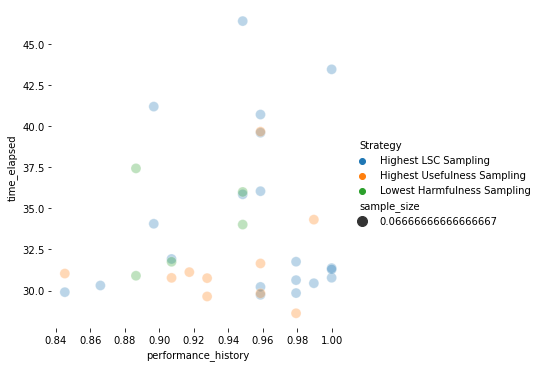

In [77]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy != "Uncertain Sampling") & (df.Strategy != "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy == "Uncertain Sampling") | (df.Strategy == "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

## Baixando datasets

In [ ]:
from tqdm.notebook import tqdm, trange
p_bar = tqdm(datalist)
for dataset_id in p_bar:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    p_bar.set_description(f'"{dataset_name}"')

In [ ]:
ds = "1465_breast-tissue.arff"

X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
   
from modAL.uncertainty import classifier_uncertainty

print(len(np.unique(y_raw)))
X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], train_size= len(np.unique(y_raw)), stratify = y_raw[idx_data[idx_bag][TRAIN]])
print(y_train)

learner = ActiveLearner (
    estimator= which_classifier(classifier), #cls,
    query_strategy=uncertainty_sampling,
    X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
)

uncertain_sample_score = learner.score(X_test, y_test)

total_of_samples = 1
while (total_of_samples != cost):

    #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)

    idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]

    if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
        #print("IF", learner.score(X_test, y_test))
        learner.teach(X_train, y_train)
        uncertain_sample_score = learner.score(X_test, y_test)
        performance_history.append(uncertain_sample_score)
    total_of_samples = total_of_samples + 1


In [ ]:
train_size= len(np.unique(y_raw)) + init_size